In [2]:
!pip install qiskit

from IPython.display import clear_output
clear_output()

In [3]:
import numpy as np
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit

In [4]:
#Create Shift Operator

#modulo N creation operator. Have to make modulo N so that it's unitary. 
def creation_operator(N):
  A = np.zeros((N,N))
  for i in range(N-1):
    A[i,i+1]=1
  A[N-1,0]=1
  return A

def creation_operator_gate(N):
  A = np.zeros((N,N))
  for i in range(N-1):
    A[i,i+1]=1
  A[N-1,0]=1
  return Operator(A)

#control shift operator = proj0 tensor A + proj1 tensor A*. Shifts N qubits with an ancilliary qubit being the control. 
#So rank is N+1 x N+1 not NxN
def control_shift(N):
  A = creation_operator(N)
  proj0,proj1 = np.zeros((2,2)), np.zeros((2,2))
  proj0[0,0] ,proj1[1,1] = 1, 1
  CS = np.kron(proj0,A) + np.kron(proj1, np.transpose(A))
  CS = Operator(CS)
  return CS



In [5]:
#Create random walk circuit
#Considers the origin to be (N+1//2,0) so I don't have to wrap around. 
def quantum_random_walk(N,simulation_time,coin):
  #max simultation time without wrap around is 2**(N-1) 
  walk = QuantumCircuit(N+1)
  #shift origin to 2**(N-1)
  indices = [k+1 for k in range(N)]
  for k in range(N//2):
    walk.append(creation_operator_gate(2**N),indices)

  #qubit 0 is the control qubit
  #h for hadamard coin
  CS = control_shift(2**N)
  if (coin == 'h'):
    for k in range(2**(N-1)):
      walk.h(0)
      walk.append(CS,range(N+1))
  return walk




In [6]:
M=9
simulation_time = 2**(M-1)
coin = 'h'

In [7]:
qc = QuantumCircuit(M,M)
qc.append(quantum_random_walk(M-1,simulation_time,'h'),range(M))
qc.measure(range(M),range(M))

In [8]:


from qiskit import IBMQ
IBMQ.save_account(token)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

/usr/local/lib/python3.6/dist-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [9]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
counts = execute(qc, simulator).result().get_counts(qc)


In [46]:
keys = counts.keys()
values = counts.values()

coin_bit = list(keys)[0][0]
#remove the coin bit, convert to decimal and shift back to the left
position =[]
for key in keys:
  position.append(int(key[1:],2)-128)

probabilities = list(values)

In [58]:
#classical random walk
def walk_the_line(N,K,step,p):
  position=[]
  for n in range(N):
    X=0
    for k in range(K):
      coin = np.random.binomial(1,p)
      X=X-step*(-1)**coin
    position.append(X)
  
  return position

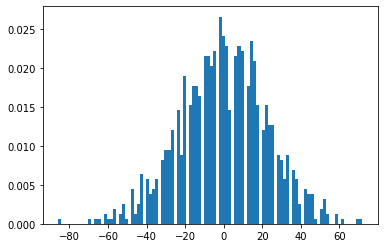

In [76]:
classical_positions = sorted(walk_the_line(1000,2**M,1,.5))
_ = plt.hist(classical_positions, density=True,bins=100,)

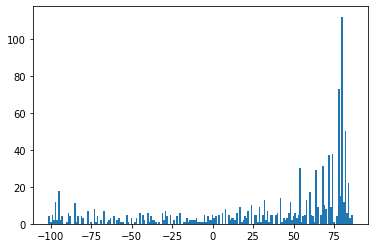

In [78]:
_ = plt.bar(position,probabilities,width=1)